In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PrintNNinfo as out
import os, subprocess
from time import time
from tqdm import tqdm
import pickle as pkl
from scipy.ndimage import gaussian_filter1d, gaussian_filter

In [2]:
def CreateERnetwork(cell_types, ps):
    n = len(ps)
    syn_types = np.arange(n*n).reshape(n, n)
    cnt_map = np.ones([len(cell_types), len(cell_types)], dtype=int) * (-1)
    
    for i, cpre in enumerate(cell_types):
        for j, cpost in enumerate(cell_types):
            if i != j:
                if np.random.uniform() < ps[cpre][cpost]:
                    cnt_map[i][j] = syn_types[cpre][cpost]
    return cnt_map


def CreateFullnetwork(cell_types, ps):
    n = len(ps)
    syn_types = np.arange(n*n).reshape(n, n)
    cnt_map = np.ones([len(cell_types), len(cell_types)], dtype=int) * (-1)
    
    for i, cpre in enumerate(cell_types):
        for j, cpost in enumerate(cell_types):
            if i != j:
                cnt_map[i][j] = syn_types[cpre][cpost]
    return cnt_map    


def get_Poisson_t(f, N, tmax, dt, t0=0):
    prob = f*dt
    times = np.arange(t0, tmax, dt)
    ts = []
    for i in range(N):
        rand = np.random.uniform(low=0, high=1e3, size=len(times))
        ids = rand < prob
        ts.append(times[ids])
    return ts

def select_targets(n_stims, n_cells, n_overlap):
    targets = []
    for i in range(n_overlap):
        targets = np.concatenate((targets, [i for i in range(n_cells)]))
    targets = list(targets.astype(np.int))
        
    target_ids = []
    for i in range(n_stims):
        tid = [np.random.choice(targets)]
        targets.remove(tid)
        for j in range(n_overlap-1):
            n = np.random.choice(targets)
            while n in tid:
                n = np.random.choice(targets)
            tid.append(n)
            targets.remove(n)
        target_ids.append(tid)
    return target_ids

def set_ext_types(target_ids, n_ext_exc, cell_types, ext_syn_types):
    n_ext_inh = len(target_ids) - n_ext_exc
#     ext_syn_types = [[0, 1], [2, 3]] # ext_PN -> ? / ext_Inh -> ?
    ext_types = []
    for i, tid in enumerate(target_ids):
        ext_types.append([])
        if i < n_ext_exc:
            pre = 0
        else:
            pre = 1
        for n in tid:
            ext_types[-1].append(ext_syn_types[pre][cell_types[n]])
    return ext_types
    
    
def show_raster(tspks, n_exc):
    for i, t in enumerate(tspks):
        if i < n_exc:
            color = 'r'
        else:
            color = 'b'
        plt.vlines(t, i-0.5, i+0.5, color=color)
    
    
def read_all(prefix):
    t, v = out.readOut(prefix+'_v.csv')
    _, ii = out.readOut(prefix+'_i.csv')
    tspks = []
    for i in range(v.shape[1]):
        tspks.append(t[v[:, i] == 30])
    return t, v, ii, tspks


def getSTFFT(x, t, wbin=50000, mbin=1000, dt=0.01, maxf=200):
    ids = np.arange(wbin//2, len(x)-wbin//2, mbin)
#     ids = np.arange(0, len(x), mbin)
    f = np.fft.fftfreq(wbin, dt/(1e3))
    f = f[:wbin//2]
    idf = (f<200) & (f>1)
    psd = np.zeros([sum(idf), len(ids)])
    window = np.hanning(wbin-1)
    for n, i in enumerate(ids):
        y = x[i-wbin//2:(i+wbin//2-1)] * window
        fx = np.fft.fft(y)/wbin
        fx = abs(fx[:wbin//2])
        psd[:, n] = fx[idf]
    return t[ids], f[idf], psd
    
    
def getFFT(x, idt, dt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

def show_grid(v, t, wbin=50000, mbin=100, s=5, norm=False, vmax=0.02):
    t, f, psd = getSTFFT(v, t, wbin=wbin)
    idf = f>10
    txy, fxy = np.meshgrid(t, f[idf])
    
    if norm:
        psd = psd - np.average(psd, axis=1).reshape(-1, 1)
    im = gaussian_filter(psd[idf, :], s)
    
    plt.pcolormesh(txy, fxy, im, cmap='jet', vmin=0, vmax=vmax)
    

In [3]:
def show_summary(t, v, tspk, n_exc):
    xl = [0, t[-1]]
    
    plt.figure(dpi=150, figsize=(9, 9))
    
    plt.subplot(511)
    show_raster(tspk, n_exc)
    plt.xlim(xl)

    plt.subplot(512)
    sv = gaussian_filter1d(np.average(v, axis=1), 5)
    plt.plot(t, sv, 'k', lw=1)
    plt.xlim(xl)

    plt.subplot(513)
    f, fx = getFFT(sv, np.ones(len(sv), dtype=bool),0.01)
    plt.plot(f, fx, 'k', lw=1)
    plt.xlim([5, 100])
    plt.ylim([0, 0.5])

    plt.subplot(514)
    show_grid(np.average(v, axis=1), t, vmax=0.02, norm=True, s=3)
    plt.xlim([0, t[-1]])
    # plt.colorbar()

    plt.subplot(515)
    show_grid(np.average(v, axis=1), t, vmax=0.2, s=3)
    plt.xlim([0, t[-1]])

    plt.tight_layout()
    plt.show()

# Pre - four cell, P-I

In [305]:
np.random.seed(10100)

tmax = 100
dt = 0.01

n_exc = 2
n_inh = 2

params_pn = {'tau':20, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':5, 'v0':-65, 'vmax':30}
params_pv = {'tau':2, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':0.2, 'v0':-65, 'vmax':30}

# set synapse type & parameter
syn_pn2pn = {'gmax':1e-3, 'tau_r':0.3, 'tau_d':6.9, 'e':0, 'd':1}
syn_pn2pv = {'gmax':5e-3, 'tau_r':0.1, 'tau_d':2.4, 'e':0, 'd':1}
syn_pv2pn = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':6.8, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':0, 'tau_r':0.5, 'tau_d':6.8, 'e':-80, 'd':1}

syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

n_cells = n_exc + n_inh
cell_types = [0, 0, 1, 1]
syn_map = [[0, 1], [2, 3]]

cnt_map = []
for i in range(4):
    cnt_map.append([])
    for j in range(4):
        if i != j:
            cnt_map[i].append(syn_map[cell_types[i]][cell_types[j]])

cnt_map = [[-1, 0, 1, 1],
           [0, -1, 1, 1],
           [2, 2, -1, 3],
           [2, 2, 3, -1]]

In [306]:
out.print_nn_params('./parameter/', 'test_4_cells', cell_types, cnt_map, [params_pn, params_pv], syn_type_params, overwrite=True)

./parameter/test_4_cells_cell.csv exists
./parameter/test_4_cells_syn.csv exists
done



In [307]:
subprocess.call(['./runNetwork_w_current',
                '--fdir', './parameter/', '--prefix', 'test_4_cells', '--fsave', './out', '--tmax', '100', '--dt', '0.01', '--s', '0.15', '--seed', '1000',
                '--t0', '0', '--t1', '%d'%(tmax), '--amp', '0.1', '--n_targets', '%d'%(n_exc)])

0

In [308]:
times, v_test, i_test, tspk_test = read_all('./out')

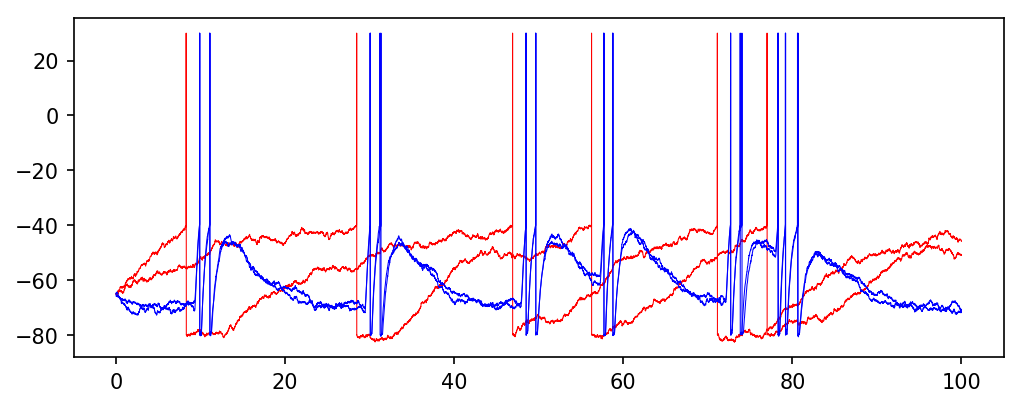

In [309]:
plt.figure(dpi=150, figsize=(8, 3))
for i in range(4):
    if i < 2:
        color = 'r'
    else:
        color = 'b'
    plt.plot(times, v_test[:, i], color, lw=0.5)
# plt.xlim([0, 10])
plt.show()

# First, Check parameter

In [143]:
np.random.seed(10100)

tmax = 500
dt = 0.01

# n_exc = 1000
# n_inh = 250
# n_stims = 1250
n_exc = 20
n_inh = 5
# n_stims = 125
# n_ext_exc = 100

# set PN cell type & cells parameter
params_pn = {'tau':20, 'r':500, 'e':-65, 'vahp':-80, 'vth':-40, 't_refrac':5, 'v0':-65, 'vmax':30}
params_pv = {'tau':2, 'r':500, 'e':-65, 'vahp':-80, 'vth':-40, 't_refrac':0.2, 'v0':-65, 'vmax':30}

# set synapse type & parameter
syn_pn2pn = {'gmax':1e-2, 'tau_r':0.2, 'tau_d':2.6, 'e':0, 'd':1}
syn_pn2pv = {'gmax':5e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
syn_pv2pn = {'gmax':5e-2, 'tau_r':0.5, 'tau_d':4.5, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':5e-3, 'tau_r':0.5, 'tau_d':4.5, 'e':-80, 'd':1}


# syn_pn2pn = {'gmax':1e-2, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':1}
# # syn_pn2pn = {'gmax':5e-3, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':1}
# syn_pn2pv = {'gmax':5e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
# syn_pv2pn = {'gmax':5e-2, 'tau_r':0.5, 'tau_d':7.5, 'e':-80, 'd':1}
# syn_pv2pv = {'gmax':5e-3, 'tau_r':0.5, 'tau_d':7.5, 'e':-80, 'd':1}

# syn_pn2pn = {'gmax':5e-3, 'tau_r':0.3, 'tau_d':6.9, 'e':0, 'd':1}
# syn_pn2pv = {'gmax':5e-4, 'tau_r':0.1, 'tau_d':2.4, 'e':0, 'd':1}
# syn_pv2pn = {'gmax':3.3e-2, 'tau_r':0.5, 'tau_d':6.8, 'e':-80, 'd':1}
# syn_pv2pv = {'gmax':3.3e-3, 'tau_r':0.5, 'tau_d':6.8, 'e':-80, 'd':1}


syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

# set network parameters
ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

n_cells = n_exc + n_inh

cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)

# cnt_map = CreateERnetwork(cell_types, ps)
cnt_map = CreateFullnetwork(cell_types, ps)

In [144]:
out.print_nn_params('./parameter/', 'ntk_check', cell_types, cnt_map, [params_pn, params_pv], syn_type_params, overwrite=True, d_noise=0.1)

./parameter/ntk_check_cell.csv exists
./parameter/ntk_check_syn.csv exists


In [145]:
subprocess.call(['./runNetwork_w_current',
                '--fdir', './parameter/', '--prefix', 'ntk_check', '--fsave', './check_params', '--tmax', '%d'%(tmax), '--dt', '0.01', '--s', '0.2', '--seed', '1000',
                '--t0', '0', '--t1', '%d'%(tmax), '--amp', '0.1', '--n_targets', '%d'%(n_exc)])

0

In [146]:
times, v_test, i_test, tspk_test = read_all('./check_params')

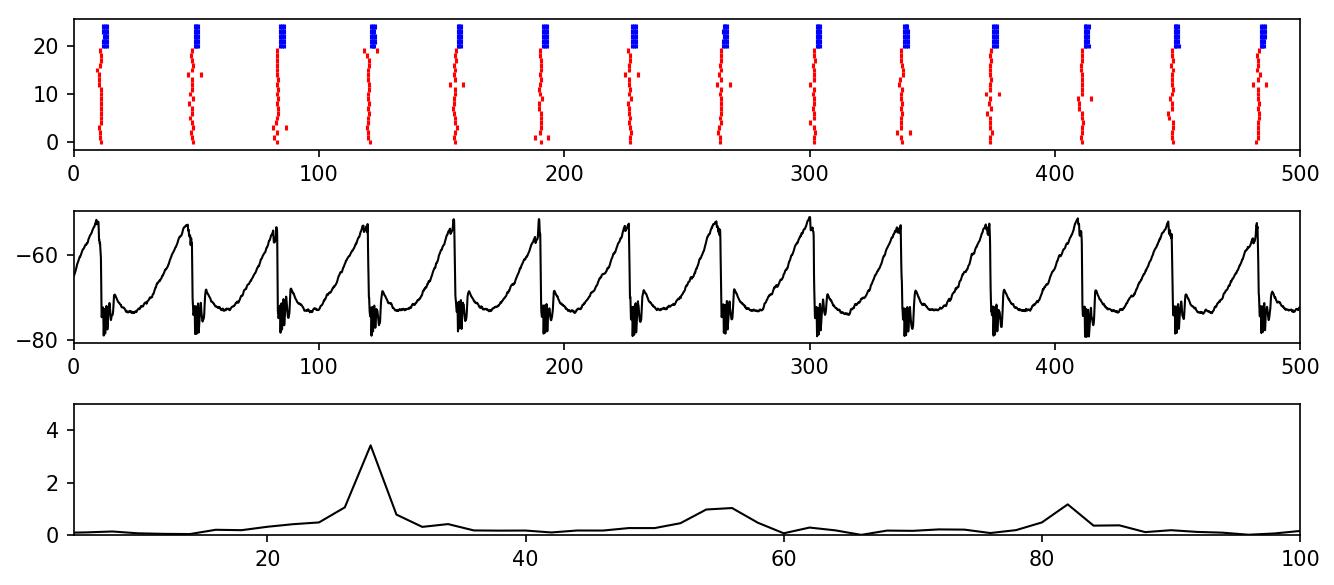

In [147]:
xl = [0, 500]

plt.figure(dpi=150, figsize=(9, 4))
plt.subplot(311)
show_raster(tspk_test, n_exc)
plt.xlim(xl)

plt.subplot(312)
sv = gaussian_filter1d(np.average(v_test, axis=1), 5)
plt.plot(times, sv, 'k', lw=1)
plt.xlim(xl)

plt.subplot(313)
f, fx = getFFT(sv, np.ones(len(sv), dtype=bool),0.01)
plt.plot(f, fx, 'k', lw=1)
plt.xlim([5, 100])
plt.ylim([0, 5])

plt.tight_layout()
plt.show()

In [134]:
si = np.std(np.average(v_test, axis=1))**2 * 25 / np.sum((np.std(v_test, axis=0)**2))
print(si)

0.4537570207758646


# Run model network

In [124]:
np.random.seed(10100)

tmax = 2000
dt = 0.01

# n_exc = 1000
# n_inh = 250
# n_stims = 1250
# n_ext_exc = 1000
n_exc = 100
n_inh = 25
n_stims = 125
n_ext_exc = 125

# set PN cell type & cells parameter
params_pn = {'tau':20, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':5, 'v0':-65, 'vmax':30}
params_pv = {'tau':2, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':0.2, 'v0':-65, 'vmax':30}

# set synapse type & parameter
# 1e-3
syn_pn2pn = {'gmax':1e-3, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':1}
syn_pn2pv = {'gmax':1e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
syn_pv2pn = {'gmax':1e-2, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}

syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

# set network parameters
ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

n_cells = n_exc + n_inh

cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)

cnt_map = CreateERnetwork(cell_types, ps)

# stimulation
ext_pn2pn = {'gmax':2e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
ext_pn2pv = {'gmax':0, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
ext_pv2pn = {'gmax':0, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}
ext_pv2pv = {'gmax':0, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}

# ext_pn2pn = {'gmax':5e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pn2pv = {'gmax':2e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pv2pn = {'gmax':5e-3, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}
# ext_pv2pv = {'gmax':5e-3, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}

# ext_pn2pn = {'gmax':2e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pn2pv = {'gmax':1.2e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pv2pn = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}
# ext_pv2pv = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}

# ext_syn_type_params = [ext_pn2pn, ext_pn2pv, ext_pv2pn, ext_pv2pv]
ext_syn_type_params = [ext_pn2pn, ext_pn2pv]

t_stims = get_Poisson_t(1, n_stims, tmax, dt, t0=0)
ids_target = select_targets(n_stims, n_cells, 10)
ext_types = set_ext_types(ids_target, n_ext_exc, cell_types, [[0, 1]])

# # external stim info
# plt.figure(dpi=150, figsize=(8, 3))
# for i, t in enumerate(t_stims):
#     plt.vlines(t, i-0.5, i+0.5, color='k', lw=0.5)
# plt.xlim([0, tmax])
# plt.show()

In [125]:
out.print_nn_params('./parameter/', 'ntk_all', cell_types, cnt_map, [params_pn, params_pv], syn_type_params,
                    ids_target, ext_types, t_stims, ext_syn_type_params, overwrite=True, d_noise=0.2)

./parameter/ntk_all_cell.csv exists
./parameter/ntk_all_syn.csv exists
./parameter/ntk_all_t_spike.csv exists


In [126]:
tic = time()
subprocess.call(['./runNetwork',
                '--fdir', './parameter/', '--prefix', 'ntk_all', '--fsave', './vcells_all', '--tmax', '%d'%(tmax), '--dt', '0.01', '--s', '0.15', '--seed', '1000'])
print(time()-tic, 's')

36.968024492263794 s


In [127]:
times, v_all, i_all, tspks = read_all('./vcells_all')

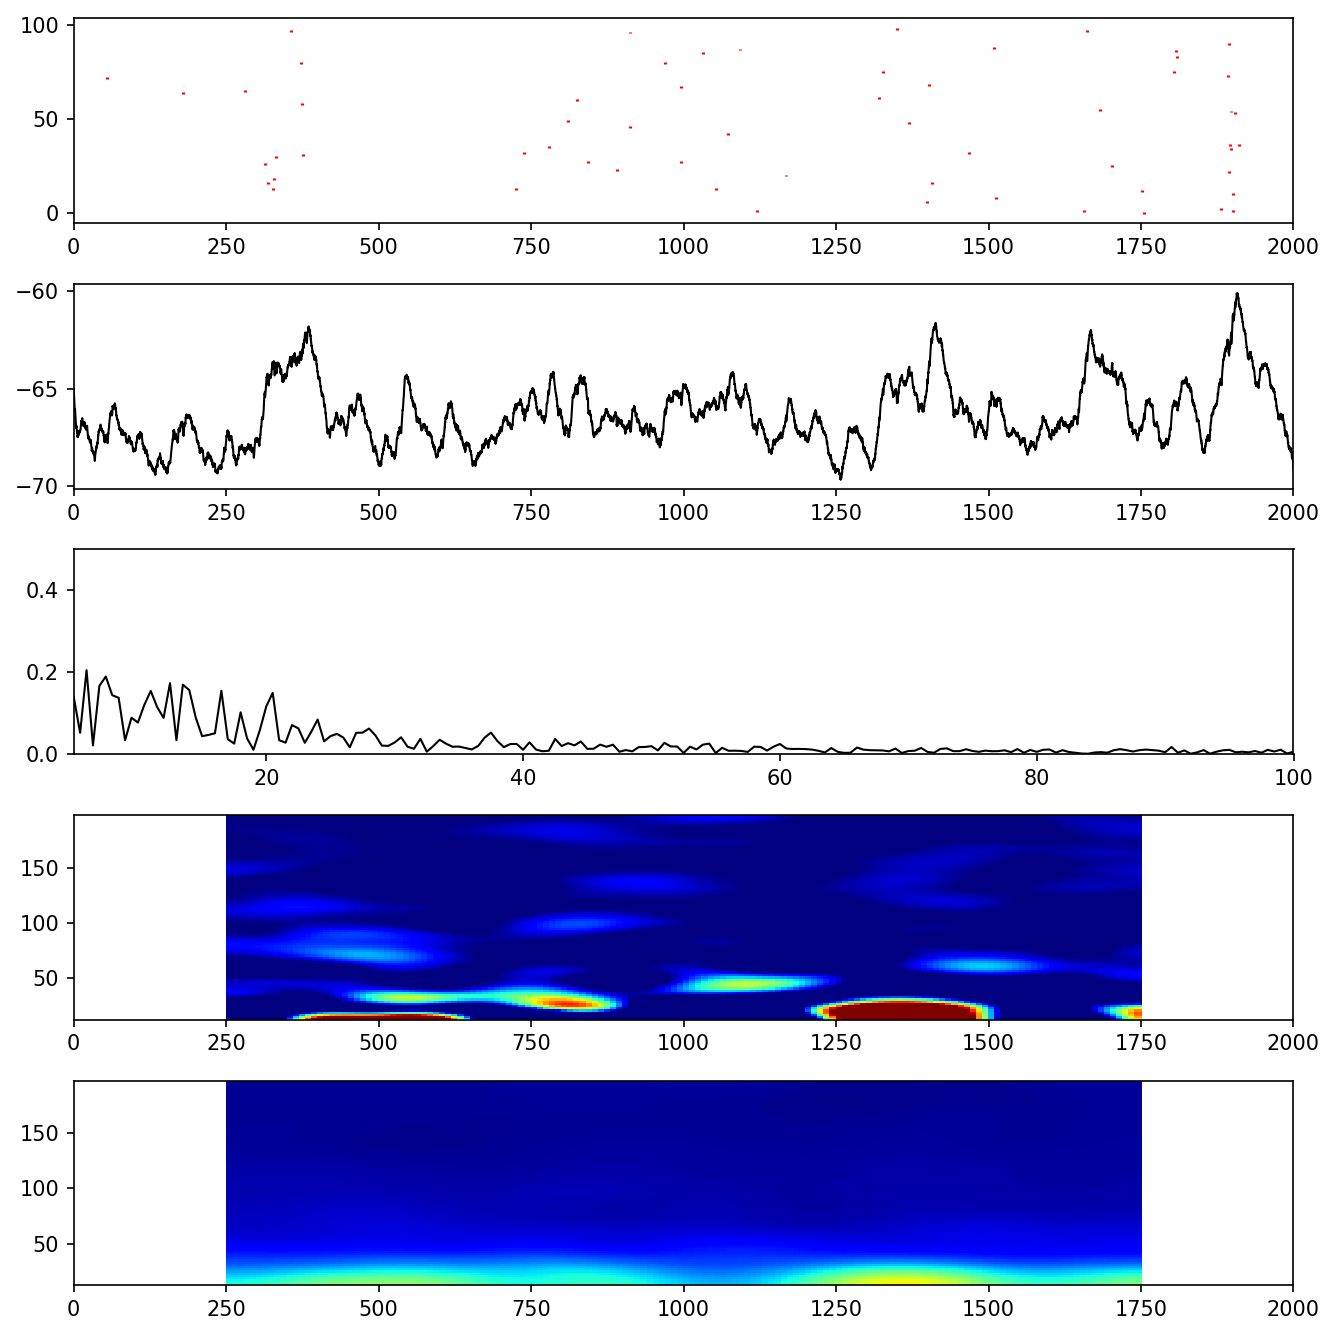

In [128]:
xl = [0, tmax]

plt.figure(dpi=150, figsize=(9, 9))
plt.subplot(511)
show_raster(tspks, n_exc)
plt.xlim(xl)

plt.subplot(512)
sv = gaussian_filter1d(np.average(v_all, axis=1), 5)
plt.plot(times, sv, 'k', lw=1)
plt.xlim(xl)

plt.subplot(513)
f, fx = getFFT(sv, np.ones(len(sv), dtype=bool),0.01)
plt.plot(f, fx, 'k', lw=1)
plt.xlim([5, 100])
plt.ylim([0, 0.5])

plt.subplot(514)
show_grid(np.average(v_all, axis=1), times, vmax=0.02, norm=True, s=3)
plt.xlim([0, tmax])
# plt.colorbar()

plt.subplot(515)
show_grid(np.average(v_all, axis=1), times, vmax=0.2)
plt.xlim([0, tmax])
# plt.colorbar()

plt.tight_layout()
plt.show()

In [259]:
si = np.std(np.average(v_all, axis=1))**2 * n_cells / np.sum((np.std(v_all, axis=0)**2))
print(si)

0.032559186074118736


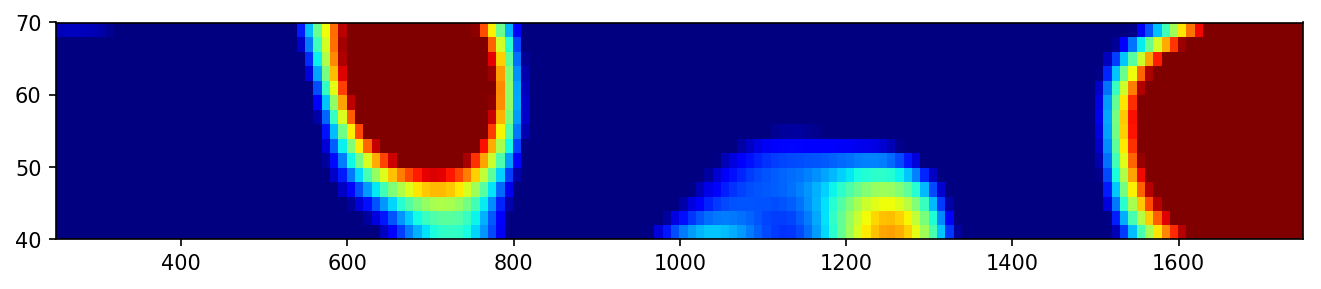

In [260]:
plt.figure(dpi=150, figsize=(9, 2))
show_grid(np.average(v_all, axis=1), times, vmax=0.02, norm=True, s=4)
plt.tight_layout()

plt.ylim([40, 70])

plt.show()

## Test with various pn->pn / pn->pv

In [87]:
# ext_pn2pn = {'gmax':1e-2, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pn2pv = {'gmax':3e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
tmax = 1000
dt = 0.01

n_pn = 5
n_pv = 5
n_itr = 1

n_exc = 100
n_inh = 25
n_stims = 125
n_ext_exc = 125
n_cells = n_exc + n_inh

ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)
cnt_map = CreateERnetwork(cell_types, ps)

seeds = [int(i) for i in np.linspace(100, 10000, n_pn*n_pv*n_itr)]

g_pns = np.linspace(1e-3, 1e-2, n_pn)
g_pvs = np.linspace(1e-3, 1e-2, n_pv)

ids_target = select_targets(n_stims, n_cells, 4)

valls_set = []
tspks_set = []

for n in tqdm(range(n_pn*n_pv*n_itr), ncols=100):
    np.random.seed(seeds[n])
    
    itr = int(n/(n_pn*n_pv))
    mod = n%(n_pn*n_pv)
    i = int(mod/(n_pn))
    j = mod%(n_pn)
    
    ext_pn2pn['gmax'] = g_pns[i]
    ext_pn2pv['gmax'] = g_pvs[j]
    
    ext_syn_type_params = [ext_pn2pn, ext_pn2pv]

    t_stims = get_Poisson_t(1, n_stims, tmax, dt, t0=0)
    
    ext_types = set_ext_types(ids_target, n_ext_exc, cell_types, [[0, 1], [2, 3]])
    
    fname = 'pn%d_pv%d_itr%d'%(i,j,itr)
    out_name = 'out_pn%d_pv%d_itr%d'%(i,j,itr)
    
    out.print_nn_params('./result_single/params/', fname, cell_types, cnt_map, [params_pn, params_pv], syn_type_params,
                        ids_target, ext_types, t_stims, ext_syn_type_params, overwrite=True)
    
    subprocess.call(['./runNetwork',
                     '--fdir', './result_single/params/',
                     '--prefix', fname, '--fsave', './result_single/output/'+out_name,
                     '--tmax', '%d'%(tmax), '--dt', '0.01',
                     '--s', '0.15', '--%d'%(seeds[n]), '1000'])
    
    fname = './result_single/output/out_pn%d_pv%d_itr%d'%(i, j, itr)
    times, vall, iall, tspks = read_all(fname)
    with open(fname+'.pickle', 'wb') as fid:
        pkl.dump(vall, fid)
        pkl.dump(iall, fid)
        pkl.dump(tspks, fid)
        pkl.dump(times, fid)
    os.remove(fname+'_v.csv')
    os.remove(fname+'_i.csv')
    
    valls_set.append(vall)
    tspks_set.append(tspks)

print('Done')

100%|███████████████████████████████████████████████████████████████| 25/25 [12:46<00:00, 30.68s/it]

Done


In [59]:
def get_sync_index(v):
    numer = np.std(np.average(v, axis=1))**2
    denom = np.average(np.std(v, axis=0)**2)
    return numer/denom

In [88]:
stds = []
for i in  range(len(valls_set)):
    stds.append(get_sync_index(valls_set[i]))
    

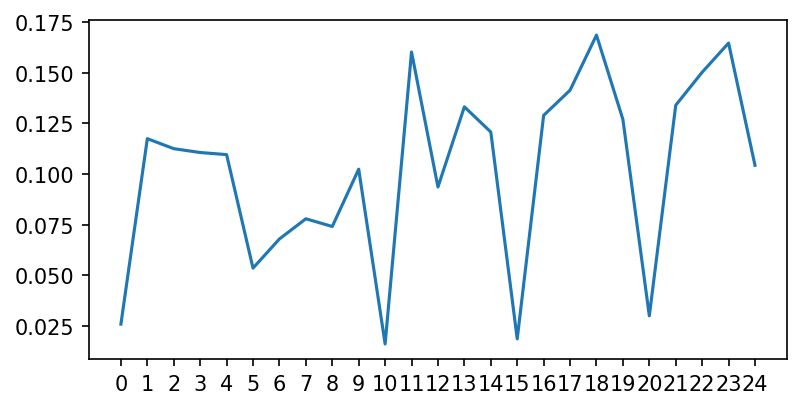

In [89]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(stds)
plt.xticks(range(25))
plt.show()

0.01
0.01
0.10423458954704974


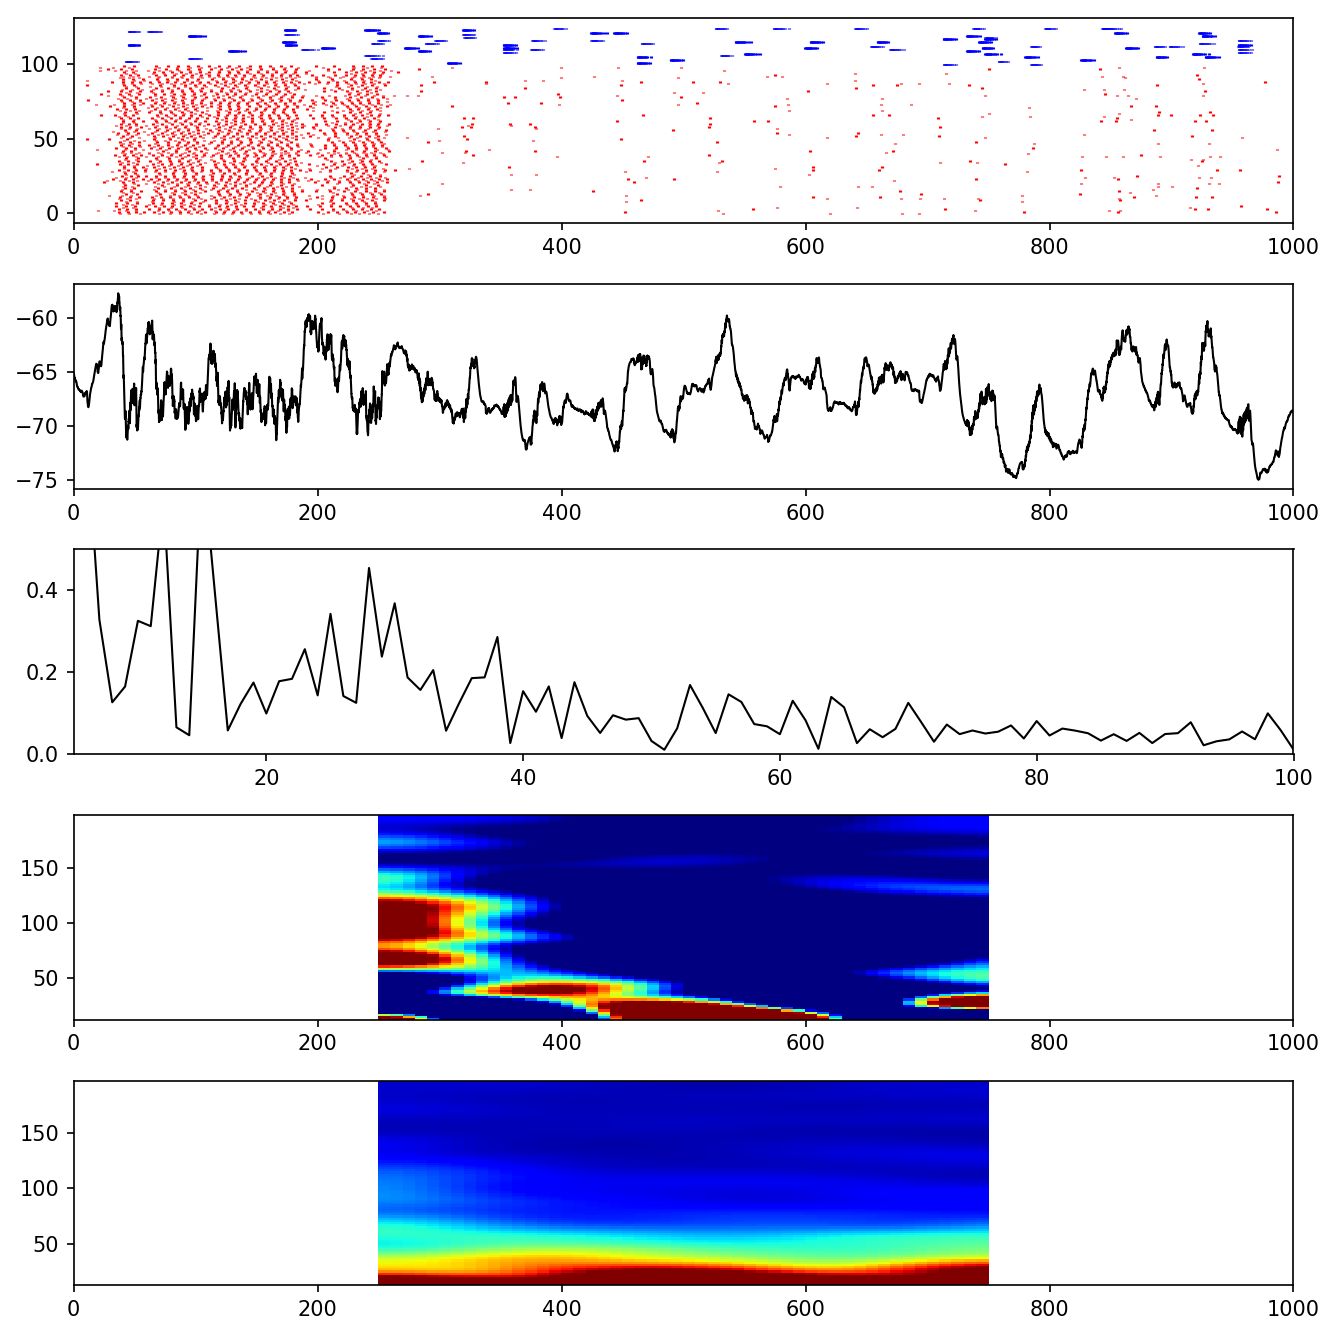

In [106]:
i = 4
j = 4
n = i*5+j
print(g_pns[i])
print(g_pvs[j])
print(stds[n])

show_summary(times, valls_set[n], tspks_set[n], 100)

## oscillatory input

In [497]:
np.random.seed(10100)

tmax = 2000
dt = 0.01

# n_exc = 1000
# n_inh = 250
# n_stims = 1250
# n_ext_exc = 1000
n_exc = 100
n_inh = 25
n_stims_30 = 50
n_stims_pos = 125

# set PN cell type & cells parameter
params_pn = {'tau':20, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':5, 'v0':-65, 'vmax':30}
params_pv = {'tau':2, 'r':500, 'e':-70, 'vahp':-80, 'vth':-40, 't_refrac':0.2, 'v0':-65, 'vmax':30}

# set synapse type & parameter
syn_pn2pn = {'gmax':1e-3, 'tau_r':0.2, 'tau_d':2.6, 'e':0, 'd':1}
syn_pn2pv = {'gmax':1e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
syn_pv2pn = {'gmax':1e-2, 'tau_r':0.5, 'tau_d':4.5, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':4.5, 'e':-80, 'd':1}

# syn_pn2pn = {'gmax':1e-3, 'tau_r':0.2, 'tau_d':4.6, 'e':0, 'd':1}
# syn_pn2pv = {'gmax':1e-4, 'tau_r':0.1, 'tau_d':1.3, 'e':0, 'd':1}
# syn_pv2pn = {'gmax':1e-2, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}
# syn_pv2pv = {'gmax':1e-3, 'tau_r':0.5, 'tau_d':7.6, 'e':-80, 'd':1}

syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

# set network parameters
ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

n_cells = n_exc + n_inh

cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)

cnt_map = CreateERnetwork(cell_types, ps)

# stimulation
# 2e-4
# 잘 안됨
ext_pn2pn30 = {'gmax':1e-2, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
ext_pn2pv30 = {'gmax':5e-2, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}

# good
# ext_pn2pn30 = {'gmax':3e-2, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pn2pv30 = {'gmax':1e-2, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}

# ext_pn2pn30 = {'gmax':1e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
# ext_pn2pv30 = {'gmax':5e-4, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}

# ext_pn2pv30 = {'gmax':3e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}

ext_pn2pn = {'gmax':4e-4, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
ext_pn2pv = {'gmax':1.5e-4, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}

# ext_syn_type_params = [ext_pn2pn, ext_pn2pv, ext_pv2pn, ext_pv2pv]
ext_syn_type_params = [ext_pn2pn30, ext_pn2pv30,  ext_pn2pn, ext_pn2pv]

t_stims = []
for i in range(n_stims_30):
    t = 500
    tmp = []
    while t < tmax-500:
        t += 1e3/30
        tmp.append(t + np.random.normal(loc=0, scale=5))
    t_stims.append(tmp)
t_stims_30 = t_stims.copy()
    
ids_targets = select_targets(50, n_cells, 1)

t_stim_pos = get_Poisson_t(1000, n_cells, tmax, dt, t0=0)
ids_target_pos = select_targets(n_stims_pos, n_cells, 10)

for t_stim in t_stim_pos:
    t_stims.append(t_stim)
    
for ids in ids_target_pos:
    ids_targets.append(ids)
    
ext_types = []
for i in range(n_stims_30+n_stims_pos):
    if i < n_stims_30:
        n1 = 0
    else:
        n1 = 1
    ids = []
    for j in ids_targets[i]:
        ctype = cell_types[j]
        
        ids.append(n1*2+ctype)
    ext_types.append(ids)

# # external stim info
# plt.figure(dpi=150, figsize=(8, 3))
# for i, t in enumerate(t_stims):
#     plt.vlines(t, i-0.5, i+0.5, color='k', lw=0.5)
# plt.xlim([0, tmax])
# plt.show()

In [501]:
np.shape(t_stims_30)

(50, 31)

In [492]:
out.print_nn_params('./parameter/', 'ntk_30', cell_types, cnt_map, [params_pn, params_pv], syn_type_params,
                    ids_targets, ext_types, t_stims, ext_syn_type_params, overwrite=True, d_noise=0.3, g_noise_syn=1e-5, g_noise_ext=0)

./parameter/ntk_30_cell.csv exists
./parameter/ntk_30_syn.csv exists
./parameter/ntk_30_t_spike.csv exists


In [493]:
tic = time()
subprocess.call(['./runNetwork',
                '--fdir', './parameter/', '--prefix', 'ntk_30', '--fsave', './vcells_30', '--tmax', '%d'%(tmax), '--dt', '0.01', '--s', '0.2', '--seed', '1000'])
print(time()-tic, 's')

76.93043112754822 s


In [494]:
times, vall, iall, tspks = read_all('./vcells_30')

In [504]:
from scipy import io

t_stim_dict = {'t': t_stims_30, 'vall': vall}
io.savemat('./tstims_test.mat', t_stim_dict)

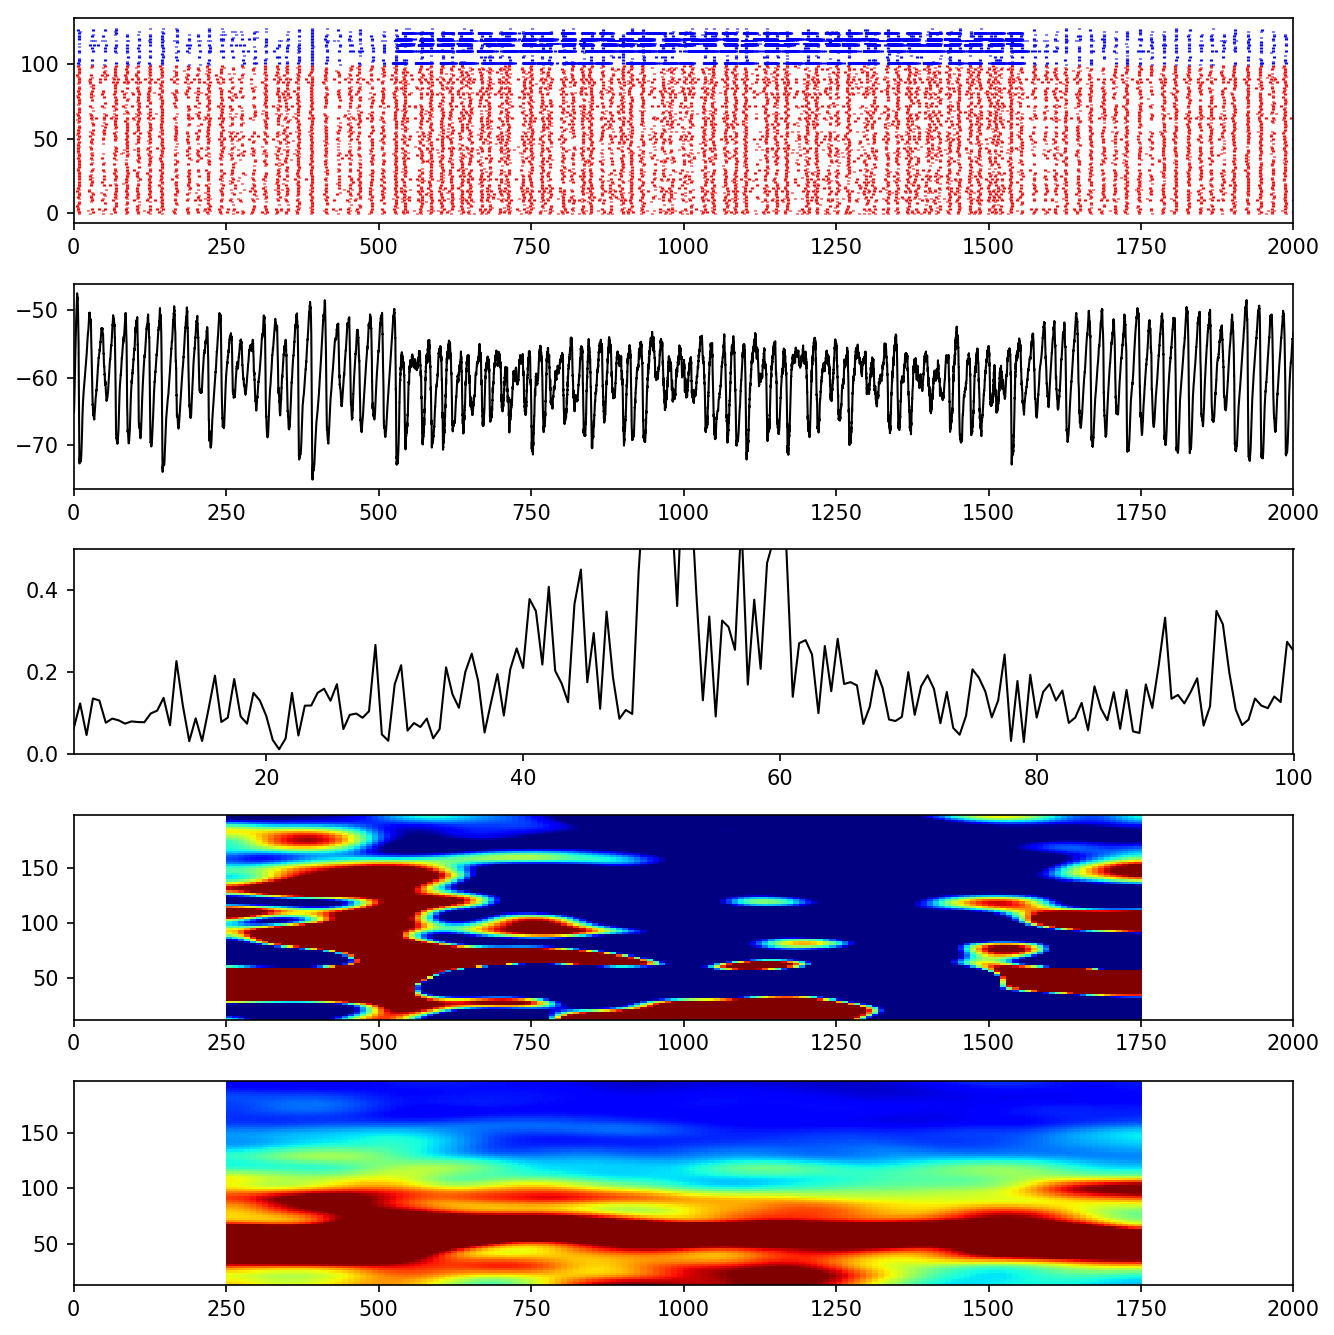

In [495]:
show_summary(times, vall, tspks, 100)

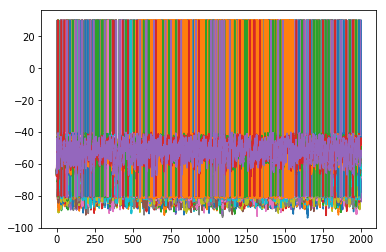

In [505]:
plt.plot(times, vall)
plt.show()

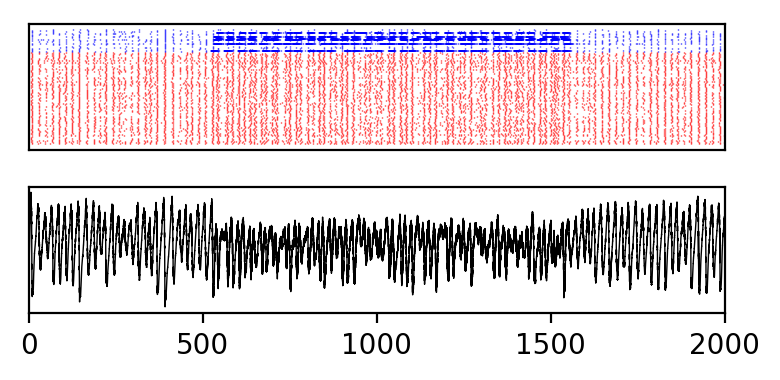

In [496]:
plt.figure(dpi=200, figsize=(4, 2))
plt.subplot(211)
for i in range(n_cells):
    if i < n_exc:
        c = 'r'
    else:
        c = 'b'
    plt.vlines(tspks[i], i-0.5, i+0.5, color=c, lw=0.5)
plt.xticks([])
plt.yticks([])
plt.xlim([0, tmax])

plt.subplot(212)
plt.plot(times, np.average(vall, axis=1), lw=0.5, c='k')
plt.yticks([])
plt.xticks(np.arange(0, 2100, 500))
plt.xlim([0, tmax])
# plt.ylabel('voltage (mV)')
    
plt.tight_layout()

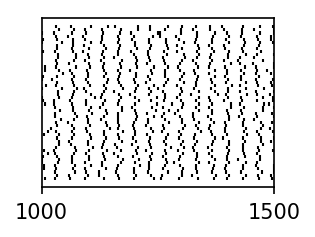

In [469]:
plt.figure(dpi=150, figsize=(2, 1.5))
for i in range(n_stims_30):
    plt.vlines(t_stims[i], i-0.5, i+0.5, 'k', lw=1)
plt.xlim([1000, 1500])
plt.yticks([])
plt.xticks(np.arange(1000, 1600, 500))
plt.show()

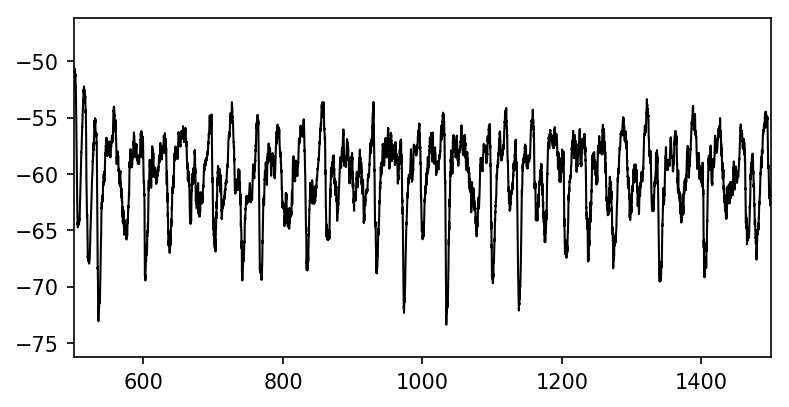

In [422]:
vsum = np.average(vall, axis=1)
sv = gaussian_filter1d(vsum, 5)

plt.figure(dpi=150, figsize=(6, 3))
plt.plot(times, sv, 'k', lw=1)
plt.xlim([500, 1500])
plt.show()

In [424]:
srate = 2000

tnew = np.linspace(0, tmax, 2*srate)
xnew = resample(sv, 2*srate)

y = butter_bandpass(xnew, [25, 35], srate, 5)

[0.025, 0.035]


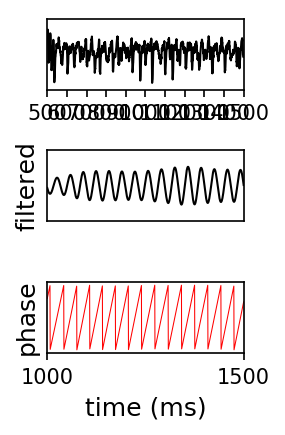

In [460]:
plt.figure(dpi=150, figsize=(2, 3))

plt.subplot(311)
plt.plot(tnew, xnew, 'k', lw=1)
plt.xticks(np.arange(500, 1700, 100))
plt.xlim([500, 1500])
plt.yticks([])

plt.subplot(312)
plt.plot(tnew, y, lw=1, c='k')

plt.xticks(np.arange(500, 1700, 500))
plt.xlim([1000, 1500])
plt.yticks([])
plt.xticks([])
plt.ylabel('filtered', fontsize=12)

plt.subplot(313)
plt.plot(tnew, np.angle(hilbert(y)), 'r', lw=0.5)
plt.xticks(np.arange(500, 1700, 500))
plt.xlim([1000, 1500])
plt.yticks([])
plt.xlabel('time (ms)', fontsize=12)
plt.ylabel('phase', fontsize=12)

plt.tight_layout()
plt.show()

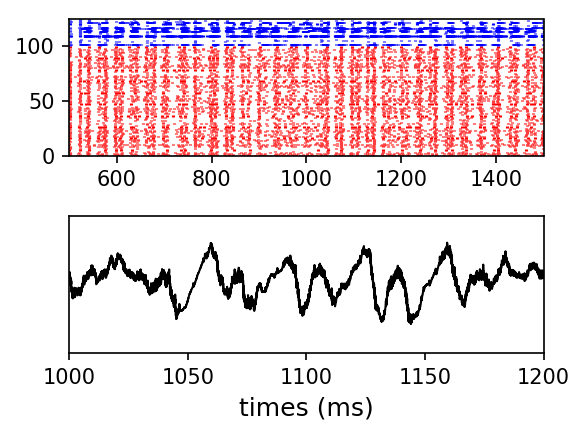

In [389]:
plt.figure(dpi=150, figsize=(4, 3))

plt.subplot(211)
for i, t in enumerate(tspks):
    if i < n_exc:
        c = 'r'
    else:
        c = 'b'
    plt.vlines(t, i-0.5, i+0.5, color=c)

plt.xlim([500, 1500])
plt.ylim([0, 125])

plt.subplot(212)
plt.plot(times, np.average(vall, axis=1), 'k', lw=1)
plt.xlim([1000, 1200])
plt.yticks([])
plt.xlabel('times (ms)', fontsize=12)

plt.tight_layout()

plt.show()

In [387]:
f, fx = getFFT(np.average(vall, axis=1), (times>800)&(times<1200), dt)

In [ ]:
from scipy import 

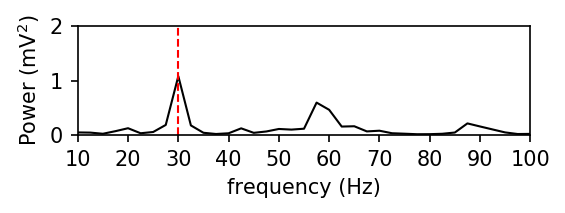

In [407]:
plt.figure(dpi=150, figsize=(4,1.5))
fid = f>10



plt.plot(f[fid], gaussian_filter1d(fx[fid]**2, 0.5), 'k', lw=1)
plt.plot([30, 30], [0, 2], 'r--', lw=1)

plt.xticks(np.arange(10, 120, 10))
plt.xlim([10, 100])
plt.ylim([0, 2])

plt.xlabel('frequency (Hz)')
plt.ylabel(r'Power (mV$^{2}$)')

plt.tight_layout()
plt.show()

In [385]:
srate = 2000

vsum = np.average(vall, axis=1)

xnew = resample(vsum, 2*srate)
xnew = gaussian_filter1d(xnew, 5)

y = butter_bandpass(xnew, [25, 35], srate, 5)

[0.025, 0.035]


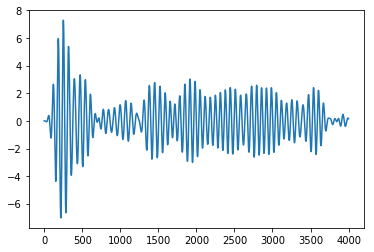

In [340]:
plt.plot(y)

In [248]:
from scipy.signal import butter, lfilter, hilbert, resample

def butter_bandpass(x, f_range, fs, order=5):
    nyq = 0.5 * fs
    f_range[0] /= nyq
    f_range[1] /= nyq
    print(f_range)
    
    b, a = butter(order, f_range, btype='band')
    
    y = lfilter(b, a, x)
    return y

def getPLV(v, t_stims, f_range, fs, order=5):
    y = butter_bandpass(v, f_range, fs, order)
    h = hilbert(y)
    phi = np.angle(hilbert(y))
    
    plv = 0
    n = 0
    for t_stim in t_stims:
        for t in t_stim:
            i = int(t/1e3*fs)
            plv += np.exp(1j*phi[i])
            n += 1
    
    plv = abs(plv) / n
    return plv
        
    

In [294]:
srate = 2000

vsum = np.average(vall, axis=1)

xnew = resample(vsum, 2*srate)
xnew = gaussian_filter1d(xnew, 5)

y = butter_bandpass(xnew, [25, 35], srate, 5)
phi = np.angle(hilbert(y))

phs = []
phi_sets = []

for ts in tspks:
    for t in ts:
        i = int(t/1e3*srate)
        phi_sets.append(phi[i])
        p = np.exp(1j*phi[i])
        phs.append(p)

[0.025, 0.035]


In [296]:
np.abs(np.average(phs))

0.03968488789971174

(array([ 821.,  939.,  918.,  899.,  732.,  843.,  943., 1161.,  986.,
         812.]),
 array([-3.13999844e+00, -2.51188316e+00, -1.88376789e+00, -1.25565262e+00,
        -6.27537341e-01,  5.77932464e-04,  6.28693206e-01,  1.25680848e+00,
         1.88492375e+00,  2.51303903e+00,  3.14115430e+00]),
 <a list of 10 Patch objects>)

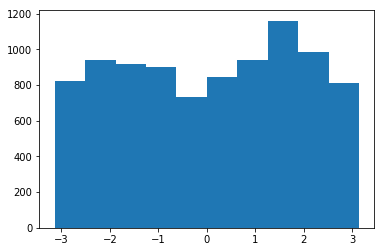

In [297]:
plt.hist(phi_sets)

In [183]:
# get PLV
vsum = np.average(vall, axis=1)

[0.02, 0.04]


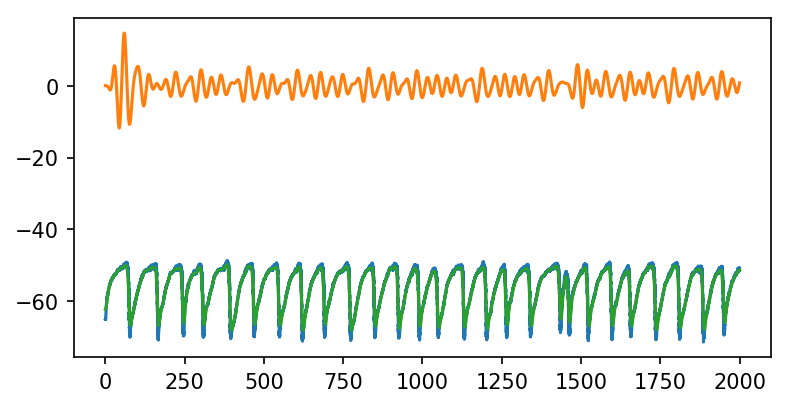

In [236]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(times, vsum)

srate = 2000

xnew = resample(vsum, 2*srate)
xnew = gaussian_filter1d(xnew, 5)

y = butter_bandpass(xnew, [20, 40], srate, 5)

plt.plot(np.linspace(0, tmax, 2*srate), y)


plt.plot(np.linspace(0, 2000, 4000), xnew)

# y = butter_bandpass(vsum, [25, 35], 1e3/dt, 5)
plt.show()

In [200]:
xnew = resample(vsum, 4000)
xnew = gaussian_filter1d(xnew, 5)
y = butter_bandpass(xnew, [25, 35], 2000, 5)

[0.025, 0.035]


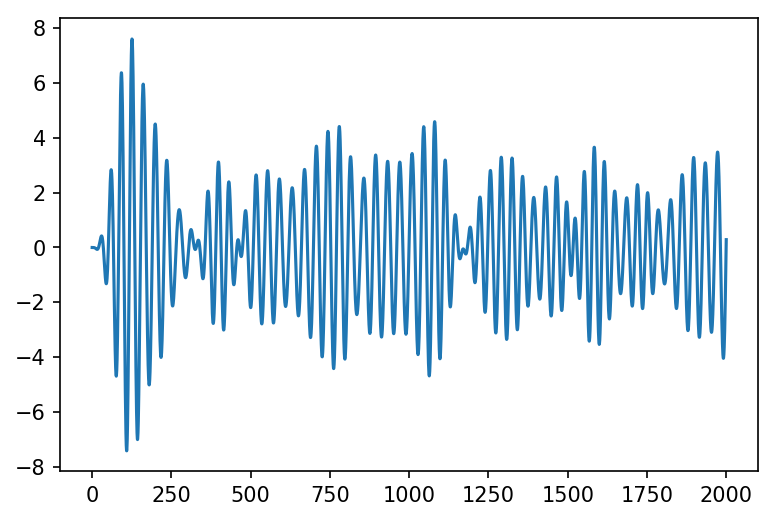

In [201]:
plt.figure(dpi=150)
plt.plot(np.linspace(0, 2000, 4000), y)
plt.show()

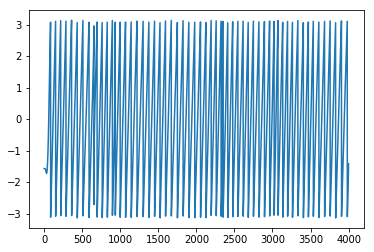

In [210]:
np.angle(hilbert(y))

In [212]:
getPLV(xnew, tspks, [25, 35], 2000, 5)

[0.025, 0.035]


0.10474251765994577

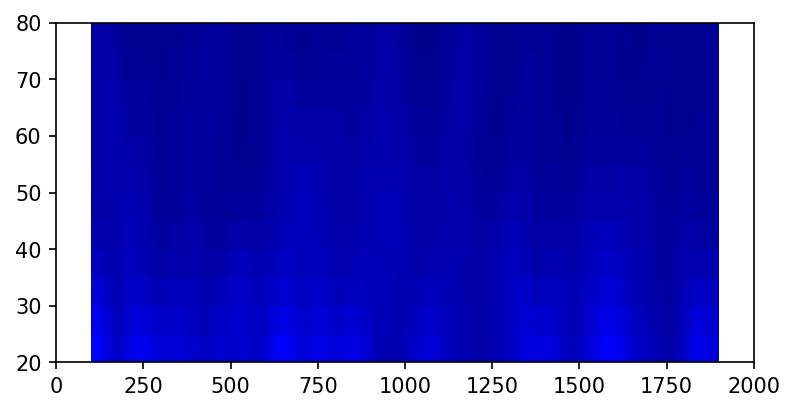

In [79]:
plt.figure(dpi=150, figsize=(6, 3))
show_grid(np.average(vall, axis=1), times, vmax=0.5, norm=False, s=2, mbin=10, wbin=int(200/dt))
plt.xlim([0, times[-1]])
plt.ylim([20, 80])
plt.show()

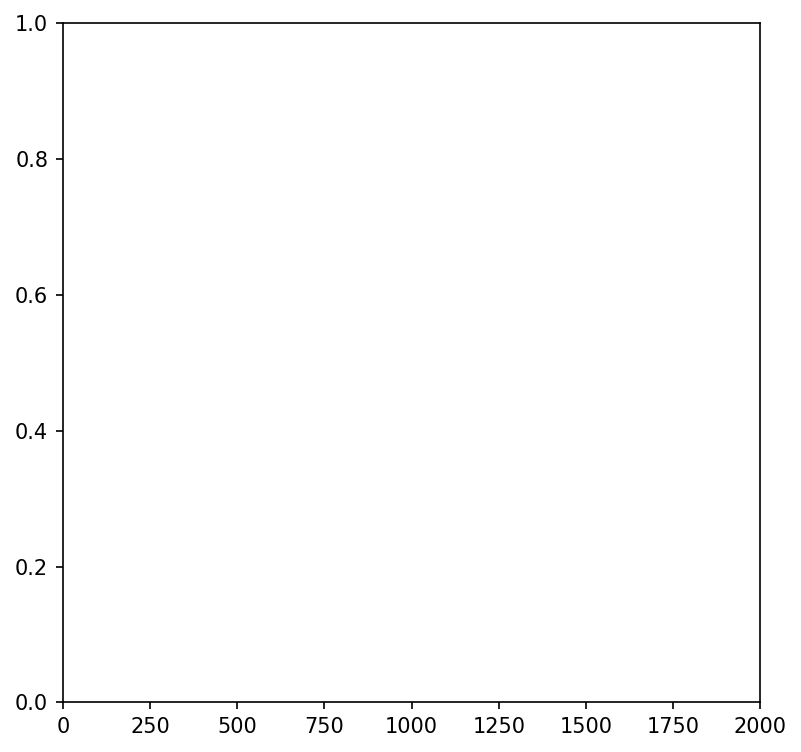

In [47]:
plt.figure(dpi=150, figsize=(6, 6))
show_raster(tspks, 100)
plt.xlim([0, tmax])
plt.show()

In [10]:
vmean = np.average(vall, axis=1).reshape(-1, 1)

mbin = 50
ids = np.arange(mbin//2, int(tmax/dt)-mbin//2, mbin)

r = []

for i in ids:
    r.append(np.average((vall[(i-mbin//2):(i+mbin//2-1)] - vmean[(i-mbin//2):(i+mbin//2-1)])**2))

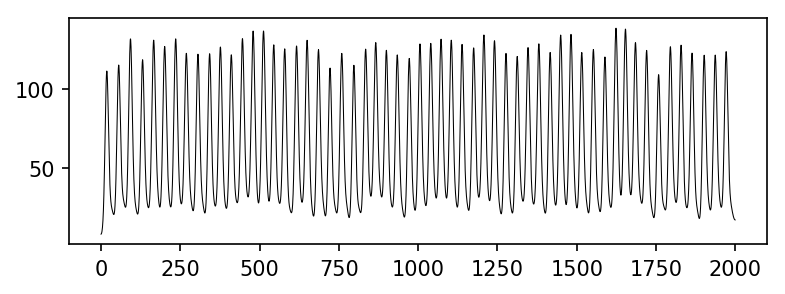

In [11]:
plt.figure(dpi=150, figsize=(6, 2))
plt.plot(times[ids], gaussian_filter1d(r, 10), 'k', lw=0.5)
plt.show()

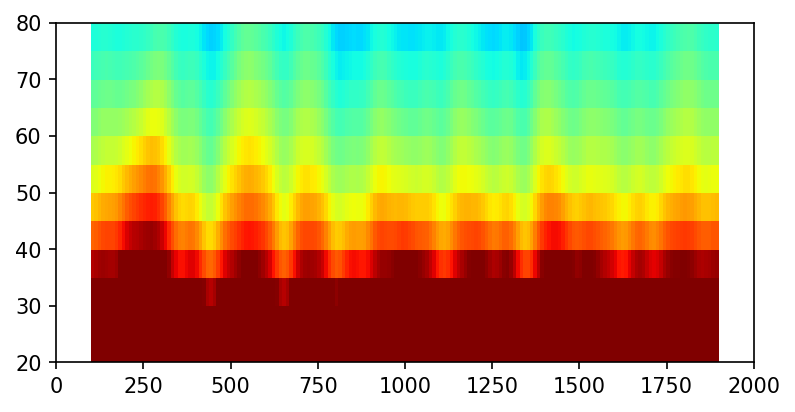

In [291]:
sv = gaussian_filter1d(np.average(vall, axis=1), 5)
f, fx = getFFT(sv, (times>500) & (times<1500),0.01)

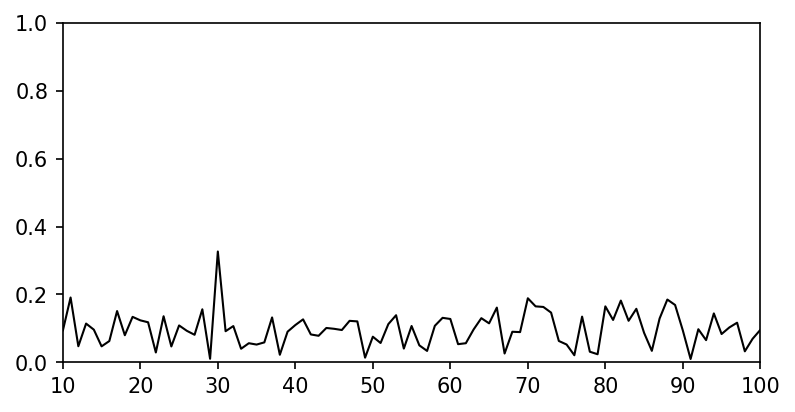

In [292]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(f, fx, 'k', lw=1)
plt.xlim([10, 100])
plt.ylim([0, 1])
plt.show()